# Comparing Methods of Vectorising Computations
Vectorised operations offer dramatic speedups by acting on multiple values at the same time. This notebook compares the speeds of different methods for vectorisation in Python including: 
- Pandas' `apply` function
- Pandas explicit expression
- Python list comprehension
- NumPy's `frompyfunc` (called in `numpy.vectorize`)
- Numba's `njit` decorator
- JAX's `vmap` function
- JAX's `vectorize` function

The test case will be to apply a simple mathematical operation (a conversion from Fahrenheit to Kelvin) to increasingly large arrays of random numbers generated by `numpy.random.normal`. These arrays will be of size $2^n$ where $n=5,\cdots,24$. The timeit library is used for profiling. Each operation is repeated 5 times and the average times are used for comparison.

Please note that these test were conducted in a CPU-only environment, and results may differ for methods which can harness GPUs or TPUs (cuDF in place of Pandas, CuPy in place of NumPy, Numba, and JAX).

In [22]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt

In [24]:
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"Numba version: {nb.__version__}")

Pandas version: 1.3.3
NumPy version: 1.20.3
JAX version: 0.2.24
Numba version: 0.54.1


In [25]:
# Function Definitions:
def fahrenheit_to_kelvin(fahrenheit_value):
    return (fahrenheit_value - 32) * 5/9 + 273.15

vec_fahrenheit_to_kelvin = np.frompyfunc(fahrenheit_to_kelvin, 1,1)

@nb.njit
def fahrenheit_arr_to_kelvin_arr(fahrenheit_values):
    result = np.empty(len(fahrenheit_values))
    for i in range(len(fahrenheit_values)):
        result[i] = (fahrenheit_values[i] - 32) * 5/9 + 273.15
    return result

In [4]:
# Results Dictionary:
results = {
    'pandas' : {},
    'pandas_apply' : {},
    'numpy_frompyfunc' : {},
    'python' : {},
    'numba_njit' : {},
    'jax_np_vectorize' : {},
    'jax_vmap' : {}
}

In [10]:
# Collect Data:
arr_lengths = []
for n in range(5, 25):
    print(f"On array size 2^{n}...")
    
    # Generate test array:
    arr_length = 2**n
    arr_lengths.append(arr_length)
    test_arr = np.random.normal(0, 1, arr_length)

    # Pandas:
    pandas_time = %timeit -q -n5 -o ((pd.Series(test_arr) - 32) * 5/9 + 273.15)
    results['pandas'][arr_length] = pandas_time

    # Pandas apply:
    pandas_apply_time = %timeit -q -n5 -o pd.Series(test_arr).apply(lambda x: fahrenheit_to_kelvin(x))
    results['pandas_apply'][arr_length] = pandas_apply_time

    # Numpy frompyfunc (called by np.vectorize):
    np_frompyfunc_time = %timeit -q -n5 -o vec_fahrenheit_to_kelvin(test_arr).tolist()
    results['numpy_frompyfunc'][arr_length] = np_frompyfunc_time

    # Python list comprehension:
    list_comp_time = %timeit -q -n5 -o [fahrenheit_to_kelvin(x) for x in test_arr]
    results['python'][arr_length] = list_comp_time

    # Numba jit
    numba_njit_time = %timeit -q -n5 -o fahrenheit_arr_to_kelvin_arr(test_arr)
    results['numba_njit'][arr_length] = numba_njit_time

    # Jax numpy vectorize:
    jax_np_vectorize_time = %timeit -q -n5 -o jnp.vectorize(fahrenheit_to_kelvin)(test_arr).block_until_ready()
    results['jax_np_vectorize'][arr_length] = jax_np_vectorize_time

    # Jax vmap:
    jax_vmap_time = %timeit -q -n5 -o jax.vmap(fahrenheit_to_kelvin)(test_arr).block_until_ready()
    results['jax_vmap'][arr_length] = jax_vmap_time

On array size 2^5...
On array size 2^6...
On array size 2^7...
On array size 2^8...
On array size 2^9...
On array size 2^10...
On array size 2^11...
On array size 2^12...
On array size 2^13...
On array size 2^14...
On array size 2^15...
On array size 2^16...
On array size 2^17...
On array size 2^18...
On array size 2^19...
On array size 2^20...
On array size 2^21...
On array size 2^22...
On array size 2^23...
On array size 2^24...


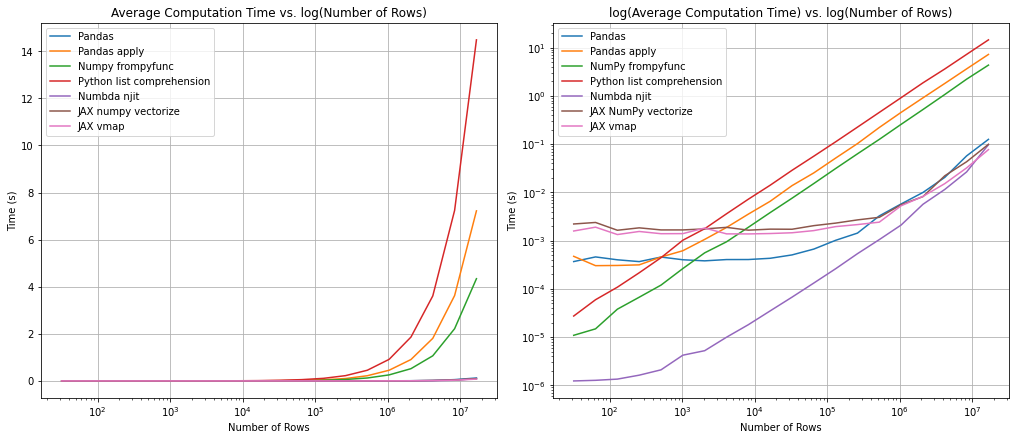

In [12]:
# Figure, Axes:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), constrained_layout=True)

# Plot Rows vs Log(Time):
ax[0].plot(arr_lengths, [results['pandas'][arr_length].average for arr_length in arr_lengths], label='Pandas')
ax[0].plot(arr_lengths, [results['pandas_apply'][arr_length].average for arr_length in arr_lengths], label='Pandas apply')
ax[0].plot(arr_lengths, [results['numpy_frompyfunc'][arr_length].average for arr_length in arr_lengths], label='Numpy frompyfunc')
ax[0].plot(arr_lengths, [results['python'][arr_length].average for arr_length in arr_lengths], label='Python list comprehension')
ax[0].plot(arr_lengths, [results['numba_njit'][arr_length].average for arr_length in arr_lengths], label='Numbda njit')
ax[0].plot(arr_lengths, [results['jax_np_vectorize'][arr_length].average for arr_length in arr_lengths], label='JAX numpy vectorize')
ax[0].plot(arr_lengths, [results['jax_vmap'][arr_length].average for arr_length in arr_lengths], label='JAX vmap')
ax[0].set_ylabel('Time (s)')
ax[0].set_xlabel('Number of Rows')
ax[0].set_xscale('log')
ax[0].set_title('Average Computation Time vs. log(Number of Rows)')
ax[0].legend()
ax[0].grid()

# Plot Rows vs Log(Time):
ax[1].plot(arr_lengths, [results['pandas'][arr_length].average for arr_length in arr_lengths], label='Pandas')
ax[1].plot(arr_lengths, [results['pandas_apply'][arr_length].average for arr_length in arr_lengths], label='Pandas apply')
ax[1].plot(arr_lengths, [results['numpy_frompyfunc'][arr_length].average for arr_length in arr_lengths], label='NumPy frompyfunc')
ax[1].plot(arr_lengths, [results['python'][arr_length].average for arr_length in arr_lengths], label='Python list comprehension')
ax[1].plot(arr_lengths, [results['numba_njit'][arr_length].average for arr_length in arr_lengths], label='Numbda njit')
ax[1].plot(arr_lengths, [results['jax_np_vectorize'][arr_length].average for arr_length in arr_lengths], label='JAX NumPy vectorize')
ax[1].plot(arr_lengths, [results['jax_vmap'][arr_length].average for arr_length in arr_lengths], label='JAX vmap')
ax[1].set_ylabel('Time (s)')
ax[1].set_xlabel('Number of Rows')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('log(Average Computation Time) vs. log(Number of Rows)')
ax[1].legend()
ax[1].grid()

# Show Plot:
plt.show()

## Remarks
The performance of these methods can be divided into three groups of increasing performance. 

The first and worst group contains Pandas `apply`, NumPy `pyfromfunc`, and Python list comprehension. The methods in this group actually perform pseudo-vectorisation and are really `for` loops. For larger DataFrames ($>10^5$ rows) vanilla Python performs the worst, Pandas `apply` performs better as it uses NumPy optimised code, and NumPy `pyfromfunc` is better still as it lacks the overheads included in Pandas objects (for holding attributes etc.).

The second group contains Pandas explicit expression, JAX `vmap`, and JAX NumPy `vectorize`. These operations are truly vectorised, with comparable performance for larger datasets and Pandas outperforming for smaller ones ($<10^{5.5}$ rows). Concerning JAX methods, while JAX `vmap` performs slightly better JAX NumPy `vectorize` is a better choice as it uses NumPy's broadcasting rules for higher dimensional objects.

The last group contains the best performer in most cases: Numba's `njit`. This method analyses and optimises using the LLVM compiler and generates machine code[^1]. For larger arrays the decorator argument `parallel=True` may further improve performance, and if mathematical rigour is not important the argument `fastmath=True` may also help. 

[^1]: Numba's compilation time was not included in the profiling as it is assumed for most cases that this can be done seperately from the computation (Numba provides explicit ahead-of-time compilation options for this purpose). This assumption may not always be true.
